# Part 2 - Pipeline with average of image for annotation

### Let's incorporate it with lane detection

In [1]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


import glob
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label

###---------------Lane Detection--------------------------------------------------------------
# Read in the saved camera matrix and distortion coefficients
# These are the arrays we calculated using cv2.calibrateCamera()
dist_pickle = pickle.load( open( "camera_cal/camera_cal_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in the saved perspective transformation matrices
# These are the arrays we calculated using cv2.getPerspectiveTransform()
dist_pickle = pickle.load( open( "camera_cal/perspective_trans_matrices.p", "rb" ) )
M = dist_pickle["M"]
Minv = dist_pickle["Minv"]


###---------------Vehicle Detection--------------------------------------------------------------
# Read in the saved vehice detection classifier and other data
dist_pickle = pickle.load( open( "training_dataset/trained_dist_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["X_scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
color_space = dist_pickle["color_space"]
hog_channel = dist_pickle["hog_channel"]
spatial_feat = dist_pickle["spatial_feat"]
hist_feat = dist_pickle["hist_feat"]
hog_feat = dist_pickle["hog_feat"]


### Define Functions

In [2]:
###-------------------------------------------------------------------------------------------
###---------------Lane Detection--------------------------------------------------------------
###-------------------------------------------------------------------------------------------
def filter_WhiteYellow(image):
    """
    Filter the image, showing only a range of white and yellow
    """
    # Filter White
    threshold = 200 
    high_threshold = np.array([255, 255, 255]) #Bright white
    low_threshold = np.array([threshold, threshold, threshold]) #Soft White
    mask = cv2.inRange(image, low_threshold, high_threshold)
    white_img = cv2.bitwise_and(image, image, mask=mask)

    # Filter Yellow
    hsv_img = cv2.cvtColor(image, cv2.COLOR_BGR2HSV) #Changing Color-space, HSV is better for object detection
    #For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255]. 
    high_threshold = np.array([110,255,255]) #Bright Yellow
    low_threshold = np.array([50,50,50]) #Soft Yellow   
    mask = cv2.inRange(hsv_img, low_threshold, high_threshold)
    yellow_img = cv2.bitwise_and(image, image, mask=mask)

    # Combine the two above images
    filtered_img = cv2.addWeighted(white_img, 1., yellow_img, 1., 0.)

    return filtered_img

def thresholding(image, M):
    """
    Apply Yellow and White Filter and create binary image
    """
    img_size = (image.shape[1], image.shape[0])
    # Filter white and Yellow to make it easier for more accurate Canny detection
    filtered_img = filter_WhiteYellow(image)
    # Convert image to gray scale
    gray = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2GRAY)
    # Create binary based on detected pixels
    binary_threshold = np.zeros_like(gray)
    binary_threshold[(gray > 0)] = 1
    # Warp the image
    warped = cv2.warpPerspective(binary_threshold, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, binary_threshold


def mag_thresh(image, sobel_kernel=5, mag_thresh=(50, 200)):
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return mag_binary


def thresholding2(img, M, sx_thresh=(20, 100)):
    img_size = (img.shape[1], img.shape[0])
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    binary_output = mag_thresh(img, sobel_kernel=5, mag_thresh=(30, 100))

    # Filter white and Yellow to make it easier for more accurate Canny detection
    filtered_img = filter_WhiteYellow(img)
    # Convert image to gray scale
    gray = cv2.cvtColor(filtered_img, cv2.COLOR_RGB2GRAY)
    binary_output2 = np.zeros_like(gray)
    binary_output2[(gray > 0)] = 1

    binary_threshold = np.zeros_like(binary_output)
    binary_threshold[((binary_output2 == 1) | (binary_output == 1))] = 1
    
    warped = cv2.warpPerspective(binary_threshold, M, img_size, flags=cv2.INTER_LINEAR)

    return warped, binary_output, binary_output2, binary_threshold


###-------------------------------------------------------------------------------------------
###---------------Vehicle Detection--------------------------------------------------------------
###-------------------------------------------------------------------------------------------

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    '''
    img: (M, N, H) ndarray
    bboxes: bounding box positions, [((x1, y1), (x2, y2)), ((,),(,)), ...]
    color: optional 3-tuple, for example, (0, 0, 255) for blue
    thick: optional integer parameter to define the box thickness
    '''
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


# Define a function to compute color histogram features 
def color_hist(img, nbins=32):
    '''
    img: (M, N, H) ndarray
    
    nbins: optional, bins is an int, it defines the number of equal-width bins in the given range
    '''
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    '''
    img: (M, N, H) ndarray
    
    size: optional 2-tuple, output image size
    '''
    # Use cv2.resize().ravel() to create the feature vector
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()

    # Return the feature vector
    return np.hstack((color1, color2, color3))


# Define a function to return HOG (Histogram of Oriented Gradient) features and visualization
def get_hog_features(img, orient=9, pix_per_cell=(8,8), cell_per_block=(8,8), 
                        vis=False, feature_vec=True):
    '''
    img: (M, N) ndarray,  single color channel or grayscaled image
    
    orient: optional, integer, and represents the number of orientation bins that the gradient information
            will be split up into in the histogram. Typical values are between 6 and 12 bins
            
    pix_per_cell: optional 2-tuple, cell size over which each gradient histogram is computed. This paramater
                  is passed as a 2-tuple so you could have different cell sizes in x and y, but cells are
                  commonly chosen to be square
                   
    cell_per_block: optional 2-tuple, and specifies the local area over which the histogram counts in a given
                    cell will be normalized. Block normalization is not necessarily required, but generally
                    leads to a more robust feature set
                    
    vis: flag tells the function to output a visualization of the HOG feature computation or not
    
    feature_vec: flag tells the function to unroll the feature array into a feature vector using same as
                 features.ravel() would do, which yields, in this case, to a one dimensional array
    '''
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=pix_per_cell,
                                  cells_per_block=cell_per_block, 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:         
        features = hog(img, orientations=orient, 
                   pixels_per_cell=pix_per_cell,
                   cells_per_block=cell_per_block, 
                   transform_sqrt=True, 
                   visualise=vis, feature_vector=feature_vec)
            
        return features

    
    
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', hist_bins=32,
                     spatial_size=(32, 32),
                     orient=9, pix_per_cell=(8,8), cell_per_block=(2,2), hog_channel=0,
                     hist_feat=True, spatial_feat=True, hog_feat=True):
    '''
    imgs:  list of image filenames
    
    color_space: optional for color feature extraction,'RGB', 'HSV', 'LUV', 'HLS', 'YUV' or 'YCrCb' 
    
    hist_bins: optional for color feature extraction, bins is an int, it defines the number of
               equal-width bins in the given range
               
    spatial_size: optional for spatial bining, 2-tuple, spatial binning output image size
    
    orient: optional for HOG feature extraction, integer, and represents the number of orientation bins
            that the gradient information will be split up into in the histogram. Typical values are
            between 6 and 12 bins
            
    pix_per_cell: optional 2-tuple, for HOG feature extraction, cell size over which each gradient histogram is computed.
                  This paramater is passed as a 2-tuple so you could have different cell sizes in x and y,
                  but cells are commonly chosen to be square
                  
    cell_per_block: optional 2-tuple, for HOG feature extraction, specifies the local area over which the
                    histogram counts in a given cell will be normalized. Block normalization is not 
                    necessarily required, but generally leads to a more robust feature set
                    
    hog_channel: optional for HOG feature extraction, which channel t apply HOG: 0, 1, 2 or "ALL"
    
    hist_feat: flag to apply or not color histogram feature extraction
    
    spatial_feat: flag to apply or not spatial binning
    
    hog_feat: flag to apply or not HOG feature extraction
    '''
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #print('len spatial_features in extract_features',len(spatial_features))
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #print('len hist_features in extract_features',len(hist_features))
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                #print('len hog_features in extract_features',len(hog_features))
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Convert color spaces
def convert_color(img, conv='RGB2YCrCb'):
    '''
    img: (M, N, H) ndarray
    conv: 'RGB2YCrCb', 'RGB2LUV', 'RGB2HSV', 'RGB2HLS' or 'RGB2YUV'
    '''
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    if conv == 'RGB2HLS':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

# Function that adds "heat" to a map for a list of bounding boxes
def add_heat(heatmap, bbox_list):
    '''
    heatmap: mask (1 channel) of original image
    bbox_list: bounding box positions, [((x1, y1), (x2, y2)), ((,),(,)), ...]
    '''
    heat_temp = np.copy(heatmap)
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heat_temp[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heat_temp# Iterate through list of bboxes


# imposing a threshold, to reject areas affected by false positives  
def apply_threshold(heatmap, threshold):
    '''
    heatmap: mask (1 channel) of original image
    threshold: reject areas affected by false positives
    '''
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


# Take labels image and put bounding boxes around the labeled regions
def draw_labeled_bboxes(img, labels):
    '''
    img: (M, N, H) ndarray
    labels: 2-tuple, where the first item is an array the size of the heatmap input image,
            and the second element is the number of labels (cars) found
    '''
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        cv2.putText(img,"Vehicle: " + "{:0.0f}".format(car_number), org=(bbox[0][0],bbox[0][1]-20), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=0.7, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    # Return the image
    return img    


### Detect lanes main functions

In [3]:
class Line():
    '''
    Keeps track of line.
    '''
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False

        # x values of the last n fits of the line
        self.recent_xfitted = []

        # average x values of the fitted line over the last n iterations
        self.bestx = None

        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None

        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]

        # radius of curvature of the line in some units
        self.radius_of_curvature = None

        # distance in meters of vehicle center from the line
        self.line_base_pos = None

        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')

        # x values for detected line pixels
        self.all_x = None

        # y values for detected line pixels
        self.all_y = None

In [4]:
def sliding_window(binary_warped):
    out_img = (np.dstack((binary_warped, binary_warped, binary_warped)) * 255).astype(np.uint8)
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)

    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low,win_y_low), (win_xleft_high,win_y_high), color=(0,255,0), thickness=2) # Green
        cv2.rectangle(out_img, (win_xright_low,win_y_low), (win_xright_high,win_y_high), color=(0,255,0), thickness=2) # Green
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]  

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    #print(left_fit) # to measure tolerances
    
    # Stash away polynomials
    left_line.current_fit = left_fit
    right_line.current_fit = right_fit
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    out_img[ploty.astype('int'),left_fitx.astype('int')] = [0, 255, 255]
    out_img[ploty.astype('int'),right_fitx.astype('int')] = [0, 255, 255]

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, deg=2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, deg=2)

    # Calculate radii of curvature in meters
    y_eval = np.max(ploty)  # Where radius of curvature is measured
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Stash away the curvatures  
    left_line.radius_of_curvature = left_curverad  
    right_line.radius_of_curvature = right_curverad
    
    return left_fit, right_fit, left_curverad, right_curverad, out_img

    
    
def non_sliding(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100

    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin))
        & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))
        & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    try:
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2) 
    except:
        return left_line.current_fit, right_line.current_fit, left_line.radius_of_curvature, right_line.radius_of_curvature, None
    
    else:
        # Check difference in fit coefficients between last and new fits  
        left_line.diffs = left_line.current_fit - left_fit
        right_line.diffs = right_line.current_fit - right_fit
        if (left_line.diffs[0]>0.001 or left_line.diffs[1]>0.4 or left_line.diffs[2]>150):
            return left_line.current_fit, right_line.current_fit, left_line.radius_of_curvature, right_line.radius_of_curvature, None
        #print(left_line.diffs)
        if (right_line.diffs[0]>0.001 or right_line.diffs[1]>0.4 or right_line.diffs[2]>150):
            return left_line.current_fit, right_line.current_fit, left_line.radius_of_curvature, right_line.radius_of_curvature, None
        #print(right_line.diffs)
        
        # Stash away polynomials
        left_line.current_fit = left_fit
        right_line.current_fit = right_fit

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, deg=2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, deg=2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        # Calculate radii of curvature in meters
        y_eval = np.max(ploty)  # Where radius of curvature is measured
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])     

        # Stash away the curvatures  
        left_line.radius_of_curvature = left_curverad  
        right_line.radius_of_curvature = right_curverad

        return left_fit, right_fit, left_curverad, right_curverad, None


In [5]:
def draw_lane(undistorted, binary_warped, left_fit, right_fit, left_curverad, right_curverad):
    
    # Create an image to draw the lines on
    warped_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warped = np.dstack((warped_zero, warped_zero, warped_zero))    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]   
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    midpoint = np.int(undistorted.shape[1]/2)
    middle_of_lane = (right_fitx[-1] - left_fitx[-1]) / 2.0 + left_fitx[-1]
    offset = (midpoint - middle_of_lane) * xm_per_pix

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warped, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    img_size = (undistorted.shape[1], undistorted.shape[0])
    unwarped = cv2.warpPerspective(color_warped, Minv, img_size, flags=cv2.INTER_LINEAR)

    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, unwarped, 0.3, 0)
    radius = np.mean([left_curverad, right_curverad])

    # Add radius and offset calculations to top of video
    cv2.putText(result,"L. Lane Radius: " + "{:0.2f}".format(left_curverad/1000) + 'km', org=(50,50), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"R. Lane Radius: " + "{:0.2f}".format(right_curverad/1000) + 'km', org=(50,100), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
    cv2.putText(result,"C. Position: " + "{:0.2f}".format(offset) + 'm', org=(50,150), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)

    return result

In [6]:
# Enlarge Inline Pictures
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = "14, 8" # or  whatever you want

In [7]:
import glob

# Make a list of images
images = glob.glob('test_images/test*.jpg')
images.sort()

In [8]:
images

['test_images/test1.jpg',
 'test_images/test2.jpg',
 'test_images/test3.jpg',
 'test_images/test4.jpg',
 'test_images/test5.jpg',
 'test_images/test6.jpg']

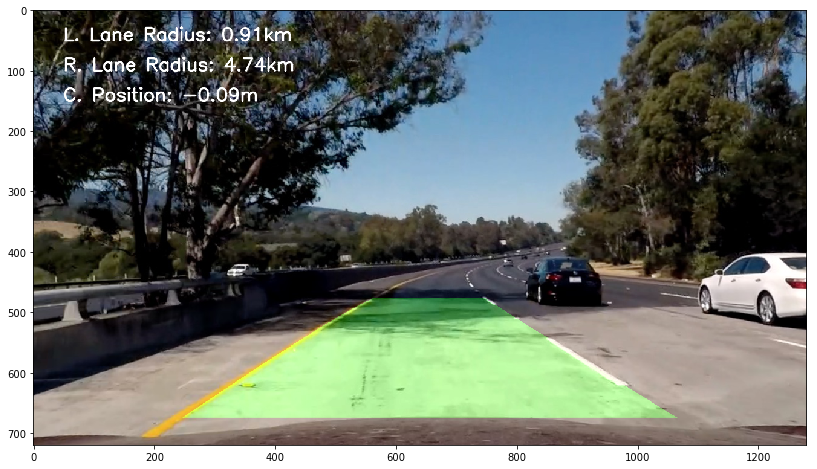

In [9]:
left_line = Line()
right_line = Line()
detected = False

img = cv2.imread(images[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
undistorted = cv2.undistort(img, mtx, dist, None, mtx)
binary_warped, binary_output2 = thresholding(undistorted, M)

if not detected:
    left_fit, right_fit, left_curverad, right_curverad, _ = sliding_window(binary_warped)
    detected = True
else:
    left_fit, right_fit, left_curverad, right_curverad, _ = non_sliding(binary_warped, left_fit, right_fit)

result = draw_lane(undistorted, binary_warped, left_fit, right_fit, left_curverad, right_curverad)

plt.imshow(result)


### Vehicle detection main functions

In [27]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler,
              orient, pix_per_cell, cell_per_block,
              spatial_size,
              hist_bins,
              window, draw_all=False):
    '''
    img: (M, N, H) ndarray
    
    ystart: y pixel coordinate at top of ROI
    
    ystop: y pixel coordinate at bottom of ROI
    
    scale: this scale factor will divide the ROI dimensions. Use >=1, where >1 will decreased dimensions
    
    svc: support vector classifier, example: LinearSVC
    
    X_scaler: normalized feature vectors
    
    orient: integer, and represents the number of orientation bins
            that the gradient information will be split up into in the histogram. Typical values are
            between 6 and 12 bins
            
    pix_per_cell: 2-tuple, cell size over which each gradient histogram is computed.
                  This paramater is passed as a 2-tuple so you could have different cell sizes in x and y,
                  but cells are commonly chosen to be square
                  
    cell_per_block: 2-tuple, specifies the local area over which the
                    histogram counts in a given cell will be normalized. Block normalization is not 
                    necessarily required, but generally leads to a more robust feature set 
    
    spatial_size: for spatial bining, 2-tuple, spatial binning output image size
    
    hist_bins: for color feature extraction, bins is an int, it defines the number of
               equal-width bins in the given range
               
    window: 2-tuple, window searching size
    '''
    draw_img = np.copy(img)
   
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    #ch2 = ctrans_tosearch[:,:,1]
    #ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell[0])-1
    nyblocks = (ch1.shape[0] // pix_per_cell[1])-1 
    nfeat_per_block = orient*cell_per_block[0]*cell_per_block[1]
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = window
    nxblocks_per_window = (window[0] // pix_per_cell[0])-1 
    nyblocks_per_window = (window[1] // pix_per_cell[1])-1 
    cells_per_step = (2,2)  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nxblocks_per_window) // cells_per_step[0] + 1
    nysteps = (nyblocks - nyblocks_per_window) // cells_per_step[1] + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    #hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Initialize a list to append window positions to
    window_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step[1]
            xpos = xb*cells_per_step[0]
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nyblocks_per_window, xpos:xpos+nxblocks_per_window].ravel() 
            #hog_feat2 = hog2[ypos:ypos+nyblocks_per_window, xpos:xpos+nxblocks_per_window].ravel() 
            #hog_feat3 = hog3[ypos:ypos+nyblocks_per_window, xpos:xpos+nxblocks_per_window].ravel() 
            #hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            hog_features = np.copy(hog_feat1)

            xleft = xpos*pix_per_cell[0]
            ytop = ypos*pix_per_cell[1]     

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window[1], xleft:xleft+window[0]], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            #test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))    
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((spatial_features, hist_features)).reshape(1, -1) )           
            
            test_prediction = svc.predict(test_features)
            
            if draw_all:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_drawx = np.int(window[0]*scale)
                win_drawy = np.int(window[1]*scale)
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_drawx,ytop_draw+win_drawy+ystart),(0,0,255),6) 

                # Calculate window position
                startx = xbox_left
                endx = startx + win_drawx
                starty = ytop_draw + ystart
                endy = starty + win_drawy

                # Append window position to list
                window_list.append(((startx, starty), (endx, endy)))
            else:
                if test_prediction == 1:
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_drawx = np.int(window[0]*scale)
                    win_drawy = np.int(window[1]*scale)
                    #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_drawx,ytop_draw+win_drawy+ystart),(0,0,255),6) 

                    # Calculate window position
                    startx = xbox_left
                    endx = startx + win_drawx
                    starty = ytop_draw + ystart
                    endy = starty + win_drawy

                    # Append window position to list
                    window_list.append(((startx, starty), (endx, endy)))
                
    #return draw_img, window_list  
    return _, window_list


In [38]:
def multi_window(img, draw_all=False):
    # Vehicle detection parameters
    #'''
    ystart = 400
    ystop = 700
    scale = 1.
    pix_per_cell=(40,30)
    window = (320,240)

    # Window searching
    out_img, box_list1 = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block,
                           spatial_size,
                           hist_bins,
                           window, draw_all=draw_all)
    #'''
    
   
    #'''
    ystart = 380
    ystop = 620
    scale = 1.
    pix_per_cell=(30,20)
    window = (240,160)

    # Window searching
    out_img, box_list3 = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block,
                           spatial_size,
                           hist_bins,
                           window, draw_all=draw_all)

    box_list1.extend(box_list3)    
    #'''
    
    #'''
    ystart = 380
    ystop = 536
    scale = 1.
    pix_per_cell=(20,13)
    window = (160,104)

    # Window searching
    out_img, box_list4 = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block,
                           spatial_size,
                           hist_bins,
                           window, draw_all=draw_all)

    box_list1.extend(box_list4)
    #'''
    
    #'''
    ystart = 400
    ystop = 490
    scale = 1.
    pix_per_cell=(10,9)
    window = (80,72)

    # Window searching
    out_img, box_list6 = find_cars(img, ystart, ystop, scale, svc, X_scaler,
                           orient, pix_per_cell, cell_per_block,
                           spatial_size,
                           hist_bins,
                           window, draw_all=draw_all)

    box_list1.extend(box_list6)
    #'''
    
    
    #print('box_list1',box_list1)
    
    return box_list1




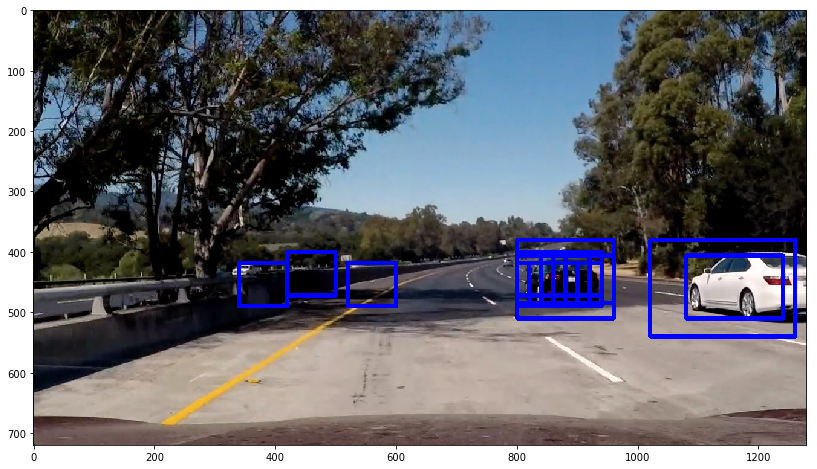

2 cars found


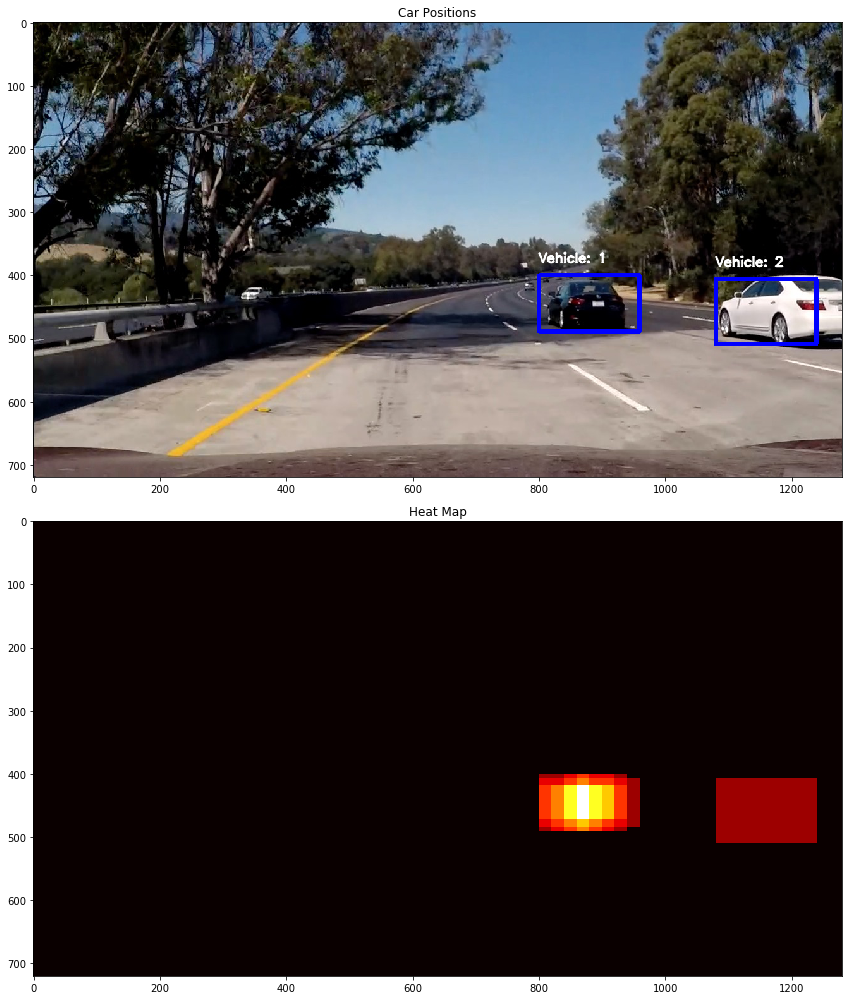

In [49]:
# Load image
box_list1 = []
img = cv2.imread(images[4])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

box_list1 = multi_window(img, draw_all=False)

result = draw_boxes(img, box_list1, color=(0, 0, 255))
plt.imshow(result)
plt.show()

# Create mask heat image 
heat = np.zeros_like(img[:,:,0]).astype(np.float)

# Add heat to each box in box list
heat = add_heat(heat,box_list1)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
print(labels[1], 'cars found')

draw_img = draw_labeled_bboxes(np.copy(img), labels)

fig = plt.figure( figsize=(14,14))
plt.subplot(211)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(212)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

### Teste on videos

In [14]:
from collections import deque

In [15]:
def get_processor(nbins=10):
    bins = nbins
    l_params = deque(maxlen=bins)
    r_params = deque(maxlen=bins)
    l_radius = deque(maxlen=bins)
    r_radius = deque(maxlen=bins)
    weights = np.arange(1,bins+1)/bins  
    
    heat_map = deque(np.array([np.zeros((720, 1280)).astype(np.float)]), maxlen=bins)

    def process_image(img):
        
        undistorted = cv2.undistort(img, mtx, dist, None, mtx)
        binary_warped, binary_output2 = thresholding(undistorted, M)
        

        if len(l_params)==0:
            left_fit, right_fit, left_curverad, right_curverad, _ = sliding_window(binary_warped)
    
        else:
            left_fit, right_fit, left_curverad, right_curverad, _ = non_sliding(binary_warped,
                                                                    np.average(l_params,0,weights[-len(l_params):]),
                                                                    np.average(r_params,0,weights[-len(l_params):]))
            
            
        l_params.append(left_fit)
        r_params.append(right_fit)
        l_radius.append(left_curverad)
        r_radius.append(right_curverad)
        annotated_image1 = draw_lane(undistorted,
                                    binary_warped,
                                    np.average(l_params,0,weights[-len(l_params):]),
                                    np.average(r_params,0,weights[-len(l_params):]),
                                    np.average(l_radius,0,weights[-len(l_params):]),
                                    np.average(r_radius,0,weights[-len(l_params):]))

        box_list = multi_window(img)
        
        # Heat mapping
        heat = np.zeros((720, 1280)).astype(np.float)
        # Add heat to each box in box list
        heat = add_heat(heat,box_list)
        
        # discard frame and use latest if nothing is identified
        heat_test = apply_threshold(heat,1)
        if np.all(heat_test<=1):
            heat_map.extend(np.array([heat_map[-1]]))
        else:
            heat_map.extend(np.array([heat]))
        
        # Apply threshold
        heat_map_avg = np.average(heat_map,0,weights[-len(heat_map):])
        heat_map_avg = apply_threshold(heat_map_avg,1)
        
        # Final annotated image
        # Visualize the heatmap when displaying    
        heat_map_clip = np.clip(heat_map_avg, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heat_map_clip)
        cv2.putText(annotated_image1,"Close Vehicles: " + "{:0.0f}".format(labels[1]), org=(50,200), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
            fontScale=1, color=(255,255,255), lineType = cv2.LINE_AA, thickness=2)
        annotated_image = draw_labeled_bboxes(np.copy(annotated_image1), labels)
        
        
        return annotated_image
    return process_image


In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
white_output = 'annotated_test_video_avg.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(get_processor(15)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video annotated_test_video_avg.mp4
[MoviePy] Writing video annotated_test_video_avg.mp4


 97%|█████████▋| 38/39 [00:28<00:00,  1.28it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: annotated_test_video_avg.mp4 

CPU times: user 1min 8s, sys: 3.12 s, total: 1min 11s
Wall time: 30 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [19]:
left_line = Line()
right_line = Line()
white_output = 'annotated_project_video_avg.mp4'
clip1 = VideoFileClip("../project_video.mp4")
white_clip = clip1.fl_image(get_processor(15)) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video annotated_project_video_avg.mp4
[MoviePy] Writing video annotated_project_video_avg.mp4


100%|█████████▉| 1260/1261 [16:47<00:00,  1.31it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: annotated_project_video_avg.mp4 

CPU times: user 38min 38s, sys: 1min 42s, total: 40min 20s
Wall time: 16min 48s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

### Try out on Project Video!